In mycase, the dataset was saved in google cloud storage. So, I needed to authenticate both bucket and drive with colab.
So, anyone can follow code after downloading dataset on their storage.

In [ ]:
# # Import PyDrive and associated libraries.
# # This only needs to be done once per notebook.
# import logging
# logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# import glob
# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###  Downloading and Saving the dataset in drive

In [ ]:
#give proper bucket address like (gs://cats_vs_dogs_dataset.zip) in place of the arrow below(remove arrow too)
!gsutil -mq cp <gs address> ./ 

In [ ]:
!unzip cats_vs_dogs_dataset.zip -d /content/drive/MyDrive/Dataset/


In [5]:
import os
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/train/dogs')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/train/cats')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/test/dogs')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/test/cats')))

8995
8995
1227
3505


### Data Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining the path to your training data directory
train_data_dir = '/content/drive/MyDrive/Dataset/dataset/train'
test_data_dir = '/content/drive/MyDrive/Dataset/dataset/test'


# Data augmentation and preprocessing for training images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

# Setting up data generators for training, validation, and testing
batch_size = 64
image_width, image_height = 224, 224
color_mode = "rgb"
seed = 42
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode=color_mode, shuffle=True,  subset='training',  seed=seed
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode=color_mode,
    shuffle=False,
    subset='validation',
    seed=seed
)

# Data augmentation for testing images
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Set up data generator for testing
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode=color_mode,
    shuffle=False
)


Found 15292 images belonging to 2 classes.
Found 2698 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.


### Custom Architecture

In [7]:
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, MaxPooling2D

# Define the input shape
input_shape = (224, 224, 3)  # 224x224 RGB image (3 channels)

# Creating a custom architecture

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

### Callback Functions

In [9]:
from keras.callbacks import Callback
import os
import shutil
save_interval = 1 # for saving model after each epoch

class SaveToBucketCallback(Callback):
    def __init__(self, num_epochs=save_interval):
        super(SaveToBucketCallback, self).__init__()
        self.num_epochs = num_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.num_epochs == 0:
            filepath = f"/content/models/Cats_vs_Dogs_custom_model-{epoch+1:02d}.h5"   #colab directory
            # Saving the model including the optimizer state
            self.model.save(filepath, include_optimizer=True)

            # copying the model file to Google Cloud Storage bucket using gsutil
            !gsutil -mq cp {filepath} <bucket address> # replace (bucket address) including the arrow, give proper bucket address if any

            print(f"{filepath} saved in bucket")

class SaveToDriveCallback(Callback):
    def __init__(self, num_epochs=save_interval, drive_path='/content/drive/MyDrive/Models'):
        super(SaveToDriveCallback, self).__init__()
        self.num_epochs = num_epochs
        self.drive_path = drive_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.num_epochs == 0:
            filepath = f"/content/models/Cats_vs_Dogs_custom_model-{epoch+1:02d}.h5"      #colab directory
            drive_path = os.path.join(self.drive_path, os.path.basename(filepath))

            # Saving the model including the optimizer state
            self.model.save(filepath, include_optimizer=True)

            # Copying the model file to Google Drive
            shutil.copy(filepath, drive_path)

            print(f"{filepath} saved in Google Drive")


In [10]:
from tensorflow.keras.callbacks import History

history = History()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define custom callbacks
save_to_bucket_callback = SaveToBucketCallback()
save_to_drive_callback = SaveToDriveCallback()

# Train the model

model.fit(
    train_generator, steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=validation_generator, validation_steps=len(validation_generator),
    callbacks=[save_to_bucket_callback, save_to_drive_callback, history]
)

Epoch 1/15
239/239 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.6843/content/models/Cats_vs_Dogs_custom_model-01.h5 saved in bucket
/content/models/Cats_vs_Dogs_custom_model-01.h5 saved in Google Drive
239/239 [==============================] - 330s 1s/step - loss: 0.7309 - accuracy: 0.6843 - val_loss: 1.7069 - val_accuracy: 0.4993
Epoch 2/15
239/239 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.7347/content/models/Cats_vs_Dogs_custom_model-02.h5 saved in bucket
/content/models/Cats_vs_Dogs_custom_model-02.h5 saved in Google Drive
239/239 [==============================] - 314s 1s/step - loss: 0.5405 - accuracy: 0.7347 - val_loss: 0.6096 - val_accuracy: 0.6950
Epoch 3/15
239/239 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.7455/content/models/Cats_vs_Dogs_custom_model-03.h5 saved in bucket
/content/models/Cats_vs_Dogs_custom_model-03.h5 saved in Google Drive
239/239 [==============================] - 307s 1

#### If runtime gets disconnected

In [ ]:
'''If runtime disconnects, run this cell to load the saved model
For example, Path to the saved checkpoint from epoch n=4
saved_checkpoint_filepath = '/content/drive/MyDrive/Models/model-04.h5'
initial_epoch=n,  # (counts from 0) It will start from epoch n+1
'''
#saved_checkpoint_filepath = ''
# model = keras.models.load_model(saved_checkpoint_filepath)

# # Resume training from where it left off
# model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     initial_epoch=n  # Start from epoch n+1
#     epochs=num_epochs,
#     validation_data=validation_generator,
#     validation_steps=len(validation_generator),
#     callbacks=[
#         save_to_bucket_callback,
#         save_to_drive_callback,
#         history
#     ]
# )

#### Visualization of loss

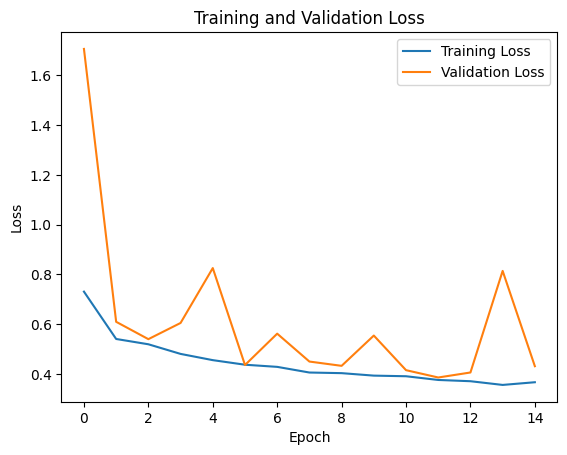

In [11]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
#This code will print the epoch number and the corresponding highest validation accuracy achieved during training

best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1    # This "+1" is for reading the epoch count from 1 not 0
print(f"The best epoch is {best_epoch} with validation accuracy: {max(history.history['val_accuracy']):.4f}")

The best epoch is 12 with validation accuracy: 0.8354


74/74 [==============================] - 23s 306ms/step


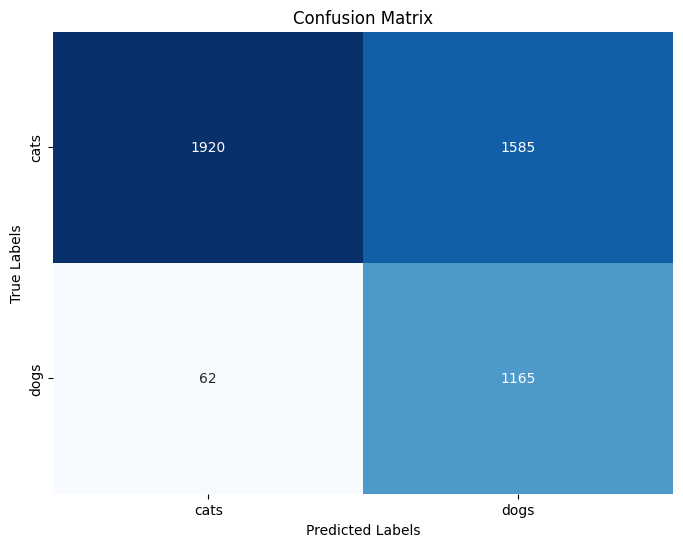

Classification Report:
               precision    recall  f1-score   support

        cats       0.97      0.55      0.70      3505
        dogs       0.42      0.95      0.59      1227

    accuracy                           0.65      4732
   macro avg       0.70      0.75      0.64      4732
weighted avg       0.83      0.65      0.67      4732



In [13]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load a saved model
loaded_model = load_model('/content/drive/MyDrive/Models/Cats_vs_Dogs_custom_model-12.h5')

# Generate predictions on test data
test_predictions = loaded_model.predict(test_generator)

# Convert predictions to binary class labels (0 or 1)  # 0 for cat, 1 for dog
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Get true labels from test generator
true_labels = test_generator.classes

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, test_predictions_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_labels = list(test_generator.class_indices.keys())
classification_rep = classification_report(true_labels, test_predictions_classes, target_names=class_labels)

print("Classification Report:\n", classification_rep)